# N-gramas

### Autores
* Aguilar Valenzuela Luis Héctor
* Camargo Loaiza Julio Andrés
* Minjares Neriz Víctor Manuel



# Creditos

Los datos de la manianera los obtuvimos del grupo @nostrodata
* GitHub : https://github.com/NOSTRODATA/conferencias_matutinas_amlo

# Importaciones
* Importamos la librería pandas para manipular fácimodel1ente los archivos <code>.csv</code>.
* Importamos la librería glob para leer fácimodel1ente los archivos <code>.csv</code>.

In [34]:
# Para libretas 1 y 2
import pandas as pd
import glob
import re
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from collections import defaultdict

# Para libretas 3
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import WittenBellInterpolated

# Libreta 1: Obtención de datos

## Limpieza de los datos
En la siguiente linea de código se usa la función <code>glob</code> para generalizar las carpetas del dataset para extraer todos los <code>.csv</code> de el mes de enero.


In [2]:
csv_files = glob.glob('conferenciasMatutinasAmlo/*/*-20*/*/mananera_*.csv')
# print(csv_files)

Ahora que tenemos las rutas, iteramos sobre ellas y guardamos todos los datos en una lista llamada <code>filelist</code>.


In [3]:
filelist = []
for file in csv_files:
    df = pd.read_csv(file)
    filelist.append(df)

In [4]:
# Numero de manianeras 
len(filelist)

1007

Observamos uno de los dataframes de la lista.

In [5]:
filelist[2]

,Participante,Texto,Sentimiento,Palabras,Dia,Mes,Anio
0,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,: Buenos días. El día de hoy vamos a presentar...,0.022805,26,27,12,2018
1,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Consideramos que se trata de un plan estratégi...,0.017787,38,27,12,2018
2,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Es un robo que el año pasado significó, en tér...",0.026243,23,27,12,2018
3,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,El año pasado se robaron diariamente más de 60...,0.106680,45,27,12,2018
4,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Si pensamos en 600 pipas diarias, no estamos s...",0.006258,52,27,12,2018
...,...,...,...,...,...,...,...
183,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,: Todo eso se está investigando y si es posibl...,0.103359,43,27,12,2018
184,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Creo que estamos nosotros informando que va en...,0.003912,57,27,12,2018
185,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Ellos pueden ayudarnos, los trabajadores, a in...",0.048008,28,27,12,2018
186,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Muy buenos días.,0.959312,3,27,12,2018


Ahora limpiamos columas que no nos sirven mediante la función <code>drop()</code> de pandas

Después filtramos los participantes para sólo tener diálogos del presidente.

In [6]:
filteredDf = []
for df in filelist:
    # Eliminamos columnas
    df = df.drop(['Sentimiento', 'Palabras', 'Dia', 'Mes', 'Anio'], axis=1)

    # Filtramos para sólo tener participaciones del presidente
    df = df[df['Participante'] == 'PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR']

    df = df.drop(['Participante'], axis=1)

    # left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    
    # filteredDf.append(left_aligned_df)
    filteredDf.append(df)


In [7]:
filteredDf[0]

,Texto
0,Buenas tardes.
1,"Sí. Es que son buenos días, pero llegué tarde,..."
2,Y hoy nos acompañó la jefa de gobierno de la C...
3,"Lo mismo del programa de protección, de apoyo,..."
4,"Mañana, les adelanto, se van a dar a conocer e..."
...,...
183,"Con todo respeto, ahí sí por voluntad en la fa..."
184,"Entonces, vamos hacia allá. Y me van a ayudar ..."
185,Vamos a que la vida pública sea cada vez más p...
186,Nos vemos mañana.


## Archivo de texto

Ahora que tenemos todos los datos filtrados, los guardaremos en un archivo, alineándolos a la izquierda y que cada oración dicha por AMLO esté en una línea.

Corpus donde cada linea es una oracion

In [9]:
with open("conferencias_matutinas_amlo.txt", "w", encoding='utf-8') as f:

    sentence = str()

    for df in filteredDf:

        for i in range(len(df)) :

            text_str = df['Texto'].iloc[i]

            for word in text_str :
                
                if word == '.' :

                    sentence += word
                    f.write(sentence.strip() + '\n')
                    sentence = str()

                else :

                    sentence += word    


# Libreta 2

## Partimos el corpus en entrenamiento y prueba de forma aleatoria

Primero contaremos el número de oraciones (lineas) que tiene nuestro corpus.

In [10]:
with open('conferencias_matutinas_amlo.txt', 'r', encoding='utf-8') as f :

    lineCount = 0

    for line in f :

        lineCount += 1

Obtenemos el número de líneas que tendra el archivo de pruebas y un arreglo con las lineas que iran en dicho archivo.

In [11]:
rd.seed(16) # Semilla 
porcentage = 20
testPart = int(lineCount*porcentage/100)


testLines = []
while len(testLines) != testPart :

    random = rd.randint(0,lineCount-1)
    
    if random not in testLines : # Si el numero random no esta ya en la lista testLines entonces agregalo

        testLines.append(random)

Ahora crearemos dos nuevos archivos, el de entrenamiento y el de prueba.

In [12]:
with open("conferencias_matutinas_amlo.txt", "r", encoding='utf-8') as f :

    with open("train.txt", "w", encoding='utf-8') as train :

        with open("test.txt", "w", encoding='utf-8') as test :

            for i, line in enumerate(f) :

                if i in testLines : # Si la linea i esta en testLines escribelo en el arhivo test

                    test.write(line)

                else : # De lo contrario va en train
                    train.write(line)


Vemos si se hizo bien la separación.

In [13]:
with open('train.txt', 'r', encoding='utf-8') as f :

    lineCountTrain = 0

    for line in f :

        lineCountTrain += 1

with open('test.txt', 'r', encoding='utf-8') as f :

    lineCountTest = 0

    for line in f :

        lineCountTest += 1

print(lineCount)
print(lineCountTrain)
print(lineCountTest)
print(lineCountTrain + lineCountTest)

224111
179289
44822
224111


Tokenizaremos el texto. La tokezinación será por oración que dijo el presidente, y cada oración estará tokenizada por palabra. Quitaremos los signos de puntuación, pero dejaremos los acentos.

## Análisis exploratorio al conjunto de entrenamiento

Para poder analizar el texto de entrenamiento, obtenemos primero un dataframe al cual le aplicaremos un análisis que incluye:
* Número de caracteres por oración
* Número de palabras por oración
* Longitud de palabras
* Palabras más frecuentes

In [29]:
# CREAR DATAFRAME A PARTIR DEL TRAIN.TXT
columns=["sentences"]
data = pd.read_csv("train.txt", delimiter="\t", header=None, names=columns)
print(data)

                                                sentences
0                                          Buenas tardes.
1                                                     Sí.
2       Es que son buenos días, pero llegué tarde, por...
3       Y hoy nos acompañó la jefa de gobierno de la C...
4       Y también se atendió el Programa de Protección...
...                                                   ...
179284                    ¿No han cambiado? Ya cambiaron.
179285                                            No, no.
179286  Ah, bueno, sí, pues si ella tiene que estar ah...
179287                                      Ah, el lunes.
179288                          Bueno, no hablaste ahora.

[179289 rows x 1 columns]


<Axes: title={'center': 'Caracteres por oración'}, xlabel='Longitud de la oración', ylabel='Frecuencia'>

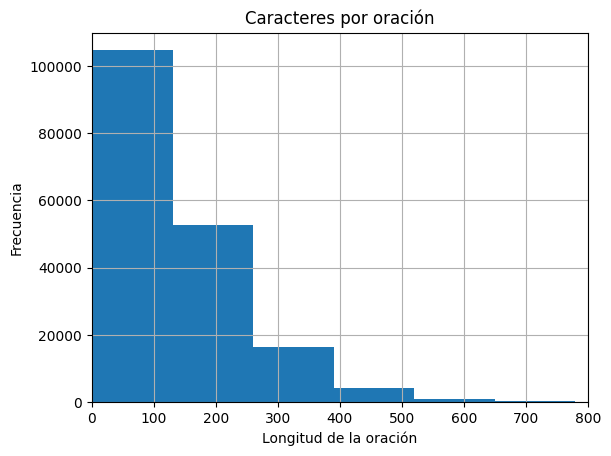

In [30]:
# HISTOGRAMA CANTIDAD DE CARACTERES POR ORACIÓN
plt.xlim([0, 800])
plt.title('Caracteres por oración')
plt.xlabel('Longitud de la oración')
plt.ylabel('Frecuencia')

data['sentences'].str.len().hist()

<Axes: title={'center': 'Palabras por oración'}, xlabel='Longitud de la oración', ylabel='Frecuencia'>

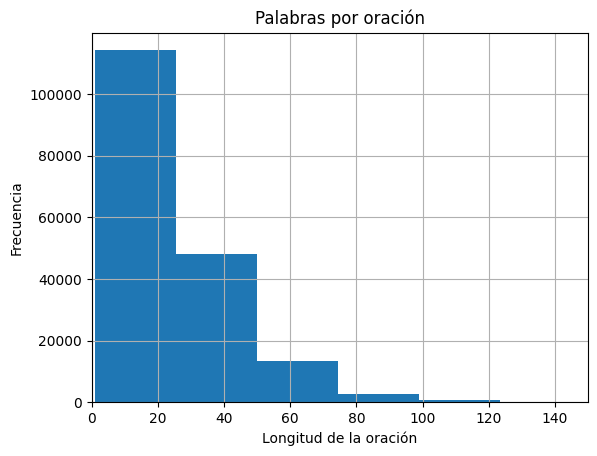

In [16]:
# HISTOGRAMA CANTIDAD DE PALABRAS POR ORACIÓN
plt.xlim([0, 150])
plt.title('Palabras por oración')
plt.xlabel('Longitud de la oración')
plt.ylabel('Frecuencia')

data['sentences'].str.split().map(lambda x: len(x)).hist()

<Axes: title={'center': 'Longitud de palabras'}, xlabel='Longitud de la palabra', ylabel='Frecuencia'>

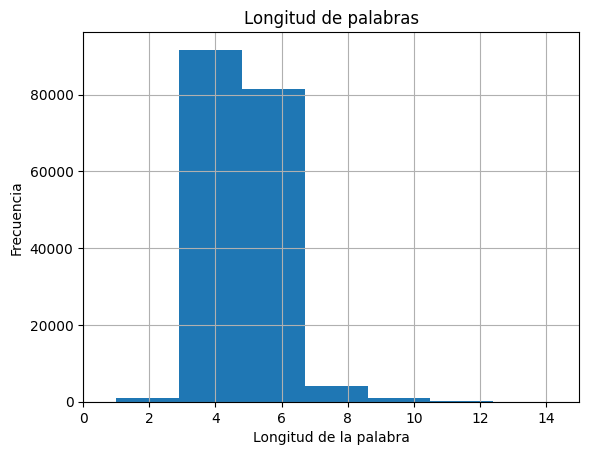

In [ ]:
# HISTOGRAMA LONGITUD DE PALABRAS
plt.xlim([0, 15])
plt.title('Longitud de palabras')
plt.xlabel('Longitud de la palabra')
plt.ylabel('Frecuencia')

data['sentences'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

111816


<Axes: >

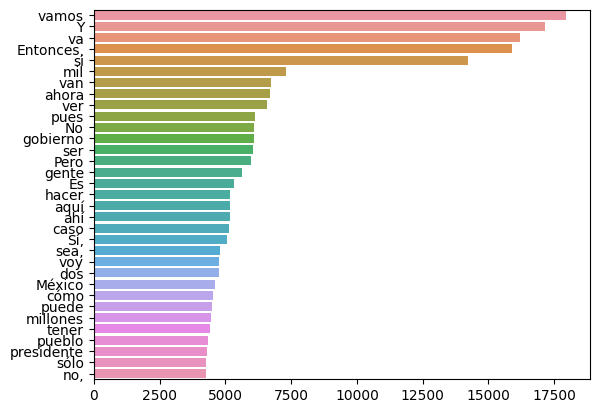

In [31]:
# convertimos nuestro dataframe a un corpus
corpus=[]
new = data['sentences'].str.split()
new = new.values.tolist()
corpus=[word for i in new for word in i]

# definimos las "stopwords" en español
stopwords_es = set(stopwords.words('spanish'))

counter=Counter(corpus)
most=counter.most_common()
print(len(counter))
x, y= [], []
for word,count in most[:100]:
    if (word not in stopwords_es):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

Podemos observar que al no tener el texto normalizado, algunas palabras con mayúsculas o comas pueden interferir en el análisis, por lo que es necesario hacer una normalización para poder conocer las palabras más frecuentes.

### Análisis normalizado

In [36]:
# FUNCIÓN PARA NORMALIZAR EL TEXTO
def noPuntuacion(text): return re.findall(r'[a-zA-ZñÑáéíóúÁÉÍÓÚüÜ]+', text.lower())
# Elimina signos de puntuación y solo deja letras en minúsculas. No elimina tildes.

#CREAR DATAFRAME NORMALIZADO A PARTIR DEL TRAIN.TXT
data["sentences_normalized"] = data["sentences"].apply(noPuntuacion).apply(lambda x: " ".join(x))

print(data)

                                                sentences  \
0                                          Buenas tardes.   
1                                                     Sí.   
2       Es que son buenos días, pero llegué tarde, por...   
3       Y hoy nos acompañó la jefa de gobierno de la C...   
4       Y también se atendió el Programa de Protección...   
...                                                   ...   
179284                    ¿No han cambiado? Ya cambiaron.   
179285                                            No, no.   
179286  Ah, bueno, sí, pues si ella tiene que estar ah...   
179287                                      Ah, el lunes.   
179288                          Bueno, no hablaste ahora.   

                                     sentences_normalized  
0                                           buenas tardes  
1                                                      sí  
2       es que son buenos días pero llegué tarde porqu...  
3       y hoy nos acompañó 

<Axes: title={'center': 'Caracteres por oración'}, xlabel='Longitud de la oración', ylabel='Frecuencia'>

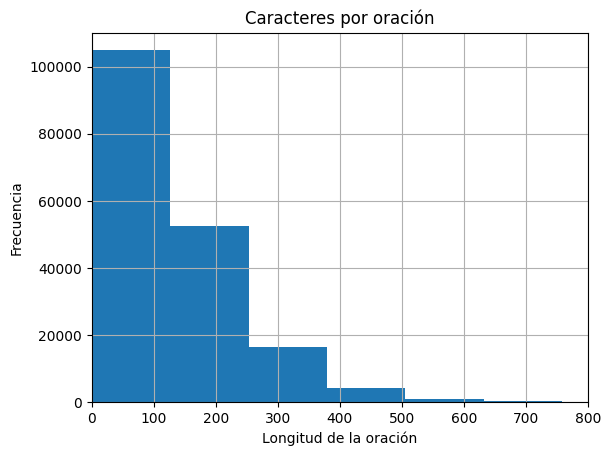

In [20]:
# HISTOGRAMA CANTIDAD DE CARACTERES POR ORACIÓN
plt.xlim([0, 800])
plt.title('Caracteres por oración')
plt.xlabel('Longitud de la oración')
plt.ylabel('Frecuencia')

data['sentences_normalized'].str.len().hist()

<Axes: title={'center': 'Palabras por oración'}, xlabel='Longitud de la oración', ylabel='Frecuencia'>

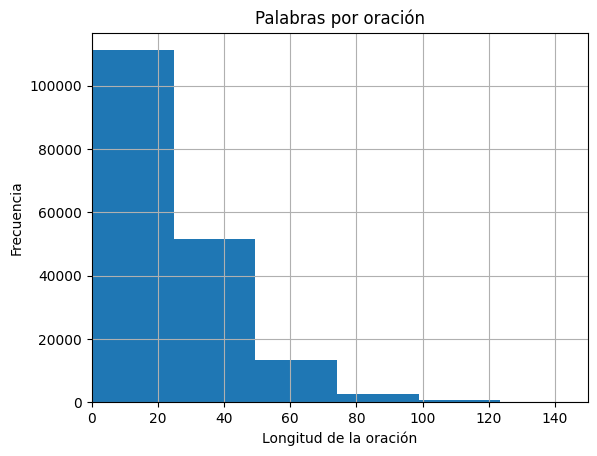

In [21]:
# HISTOGRAMA CANTIDAD DE PALABRAS POR ORACIÓN
plt.xlim([0, 150])
plt.title('Palabras por oración')
plt.xlabel('Longitud de la oración')
plt.ylabel('Frecuencia')

data['sentences_normalized'].str.split().map(lambda x: len(x)).hist()

<Axes: title={'center': 'Longitud de palabras'}, xlabel='Longitud de la palabra', ylabel='Frecuencia'>

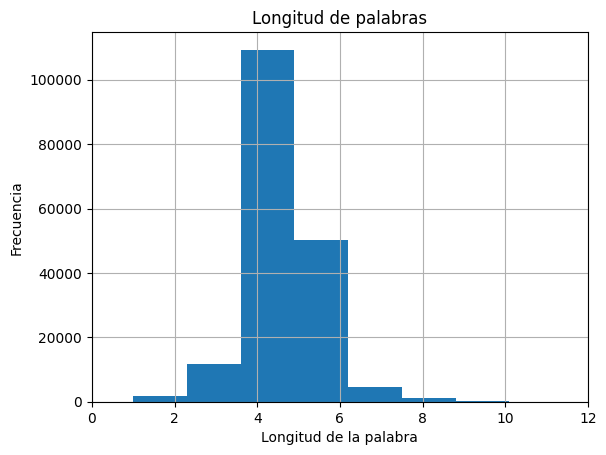

In [23]:
# HISTOGRAMA LONGITUD DE PALABRAS
plt.xlim([0, 12])
plt.title('Longitud de palabras')
plt.xlabel('Longitud de la palabra')
plt.ylabel('Frecuencia')

data['sentences_normalized'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

42663


<Axes: >

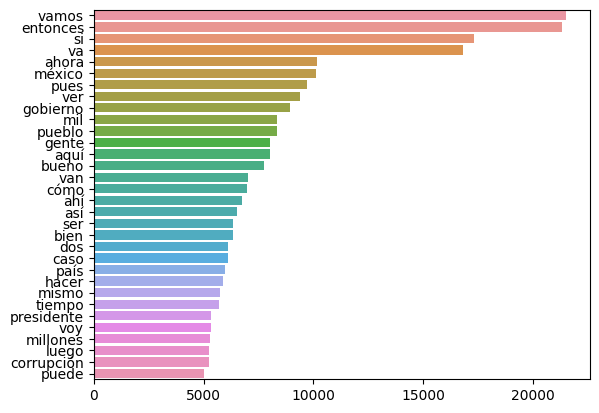

In [24]:
# Creación del corpus
corpus_normalized=[]
new = data['sentences_normalized'].str.split()
new = new.values.tolist()
corpus_normalized=[word for i in new for word in i]

# Filtrar stopwords en el corpus
palabras_filtradas = [word for word in corpus_normalized if word not in stopwords_es]

# Graficar palabras más frecuentes
counter=Counter(corpus_normalized)
most=counter.most_common()
print(len(counter))
x, y= [], []
for word,count in most[:100]:
    if (word not in stopwords_es):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)      

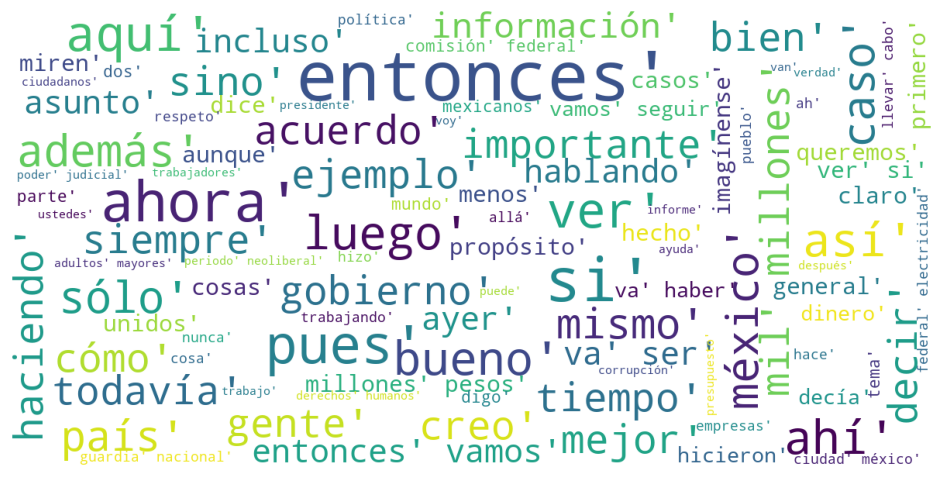

In [33]:
# WORDCLOUD
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(palabras_filtradas)

#### Interpretación del análisis
* Número de caracteres por oración 
        
        Las oraciones tienen una longitud entre 1 y 800 caracteres, siendo la mayoría entre 1 y 125.
        
* Número de palabras por oración

        Las oraciones tienen una longitud entre 1 y 125 palabras, siendo la mayoría entre 1 y 25.
* Longitud de palabras

        Las palabras tienen una longitud entre 1 y 10 caracteres, siendo la mayoría entre 3.5 y 6.
* Palabras más frecuentes

        Algunas de las palabras más frecuentes son "vamos", "entonces", "si", "va", etc. Aunque si vemos algunas palabras que nos puedan dar más contexto, alguna de ellas podrían ser "México", "gobierno", "pueblo", "gente", "país", "presidente", "corrupción", etc.

## Creación de la estructura (lista de listas) para usarlo en los n-gramas

Diccionario de palabras.

In [35]:
# El vocabulario que obtendremos sera tan que las palabras compuestas por - o de otra manera las tomara como 1, 
# por ejemplo : Azul-América, se convertira a azulamerica.
Vocab=defaultdict(int)
for word in corpus :
    Vocab[''.join(noPuntuacion(word))] += 1

print("Diccionario : ")
print(Vocab)
print("tamanio de vocabulario :" + str(len(Vocab)))

Diccionario : 
defaultdict(<class 'int'>, {'buenas': 565, 'tardes': 24, 'sí': 16986, 'es': 71168, 'que': 184761, 'son': 11575, 'buenos': 1784, 'días': 2871, 'pero': 29218, 'llegué': 110, 'tarde': 556, 'porque': 31001, 'estábamos': 413, 'tratando': 214, 'temas': 757, 'importantes': 442, 'desde': 5994, 'luego': 5260, 'el': 109237, 'tema': 2413, 'de': 198934, 'la': 129635, 'seguridad': 2782, 'y': 114170, 'hoy': 3098, 'nos': 15190, 'acompañó': 33, 'jefa': 250, 'gobierno': 8877, 'ciudad': 1883, 'méxico': 10026, 'estuvo': 520, 'en': 92444, 'reunión': 1213, 'del': 32151, 'gabinete': 463, 'también': 14652, 'se': 89065, 'atendió': 48, 'programa': 1746, 'protección': 876, 'a': 134380, 'peregrinos': 4, 'ya': 29660, 'estamos': 11241, 'víspera': 24, 'día': 2837, '': 30242, 'vienen': 556, 'país': 5949, 'por': 32814, 'las': 30851, 'carreteras': 193, 'lo': 54030, 'mismo': 5739, 'apoyo': 2341, 'buen': 1059, 'trato': 297, 'evitar': 533, 'extorsiones': 14, 'mordidas': 22, 'nuestros': 1684, 'paisanos': 46

Para elegir que palabras del diccionario las convertiremos a los token  <code>\<UNK></code>, veremos cual es el promedio y la mediana de las frecuencias.

Observamos uno de los dataframes para confirmar que las columnas se eliminaron y sólo hay participaciones del presidente.


In [22]:
mean_frequency = sum(Vocab.values()) / len(Vocab)
print("Promedio de frecuencias del vocabulario : " + str(mean_frequency))


values = sorted(Vocab.values())
n = len(values)
if n % 2 == 0:
    median_frequency = (values[n//2 - 1] + values[n//2]) / 2.0
else:
    median_frequency = values[n//2]

print("Mediana de frecuencias del diccionario : " + str(median_frequency))
print("Frecuencias ordenadas del diccionario : ")
print(sorted(values))


word1freq = 0
for word in values :
    if word == 1 :
        word1freq += 1

print("Numero de palabras que solo aparecen una vez en el diccionario : " + str(word1freq))


Promedio de frecuencias del vocabulario : 85.96366608766732
Mediana de frecuencias del diccionario : 2
Frecuencias ordenadas del diccionario : 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Si comparamos con el tamanio del vocabulario vemos que el **40%** son palabras que sólo aparecen una vez en nuestro texto de entrenamiento, lo cual es una cantidad muy considerable. Por lo tanto, optaremos por sólo hacer **10%** de las palabras que sólo aparecen una vez como <code>\<UNK></code>, esto es 1915 palabras del diccionario.

In [23]:
unkPorcentage = 10
nUnk = int(word1freq*unkPorcentage/100)
unkWord = []
i = 0
for key, value in Vocab.items() :


    if value == 1 :

        unkWord.append(key)
        i += 1 

    if i == nUnk :
        break

print("Palabras que se convertiran en token <UNK> :")
print(unkWord)
print("Numero de palabras que cambiaremos por <UNK> : " + str(len(unkWord)))

Palabras que se convertiran en token <UNK> :
['mezcalapa', 'típica', 'dividían', 'superdelegado', 'adjetivar', 'azulamérica', 'fisuras', 'intachables', 'corrupciónlos', 'recurrirá', 'acordonada', 'consistirá', 'caracterizarse', 'sentándome', 'neofascistas', 'mostrarlos', 'ocultara', 'emitieran', 'charlatanerías', 'tiznar', 'definitorias', 'transporten', 'reservadas', 'conducidas', 'nadaque', 'confeti', 'endurecen', 'aparenten', 'relate', 'taparle', 'fraguaba', 'mencionarla', 'construiría', 'planteamientoy', 'congeladora', 'revivirlas', 'originar', 'acabárselo', 'potente', 'crecíamos', 'desdichada', 'asustados', 'aborde', 'vulcanizadora', 'desponchadora', 'formarlo', 'pervertir', 'repartos', 'resiente', 'téngannos', 'indagas', 'tlalnepantla', 'imprecisa', 'abunde', 'diariaspero', 'empacado', 'persiguiéndolo', 'concretado', 'salazarcon', 'afligir', 'benevolencia', 'rompernos', 'farjat', 'escudaban', 'albergo', 'engomados', 'colabore', 'extralimitan', 'incomunicado', 'deliberadas', 'recor

Por último, crearemos la lista de listas, donde las palabras de la lista <code>unkWord</code> seran reemplazadas por el token <code>\<UNK></code>.

In [24]:
textToNgrams = []
countUnk = 0

with open("train.txt", "r", encoding='utf-8') as fRead :

    for line in fRead :

        # Por como hicimos el diccionario, donde las palabras compuestas con - o de otra manera nos conviene usar
        # .split() primero, ya que este hace separacion por espacios y nos deja como una la palabra compuesta, 
        # a diferencia de si primero aplicamos noPuntuacion() que esta funcion si nos descompone las palabras compuestas.

        # words = noPuntuacion(line)
        words = line.split()
        # print(words)

        for i,word in enumerate(words) :

            # print(word)     

            cleanWord = ''.join(noPuntuacion(word)) # Con esto dejamos las palabras compuestas como una pero limpias.

            if cleanWord in unkWord :
                words[i] = "<UNK>"
                countUnk += 1
            else :
                words[i] = cleanWord

        textToNgrams.append(words)
        

Vemos que realmente están todos los token <code>\<UNK></code>.

In [25]:
countUnk = 0 
for sentence in textToNgrams :
    for word in sentence :
        if word == '<UNK>' :
            countUnk += 1

print("Numero de token <UNL> en textToNgrams : " + str(countUnk))

Numero de token <UNL> en textToNgrams : 1915


# Libreta 3

## Entrenamiento del modelo

Ya que tenemos una lista de listas con todas las palabras tokenizadas, debemos de crear un n-grama de entrenamiento y el vocabulario.

- Creamos el n-grama de entranamiento

    - Primero acolchonamos las oraciones. Esto es poner uno o mas simbolos como inicio (\<s>) y otro como fin (<\s>) de oracion. Este acolchonamiento en la paqueteria de nltk es simetrico, esto es pone el mismo numero de simbolos al inicio como al final. La salida sera una lista de listas pero acolchonada
    - Segundo convertir a un n-grama. Con la salida del paso anterior crearemos nuestro unigrama, bigrama, trigrama, etc. Para hacer el modelo mas robusto se pueden hacer n,(n-1),..,.1-gramas, esto es, si tenemos que el n-grama maximo que queremos es un trigrama, tambien podemos hacer bigramas y unigramas. La salida sera una lista de lista con el/los n-grama(s).

- Creamos el vocabulario

    - A la lista de listas acolchonada que hicimos en la creacion del n-grama simplemente la aplanamos, esto es, pasamos de una lista de listas a solo una lista donde tendremos todas las palabras de nuestro texto tokenizadas. La salida sera una lista acolchonada con las palabras tokenizadas.

Para suerte de nosotros la paqueteria nltk ya tiene una funcion para realizar todo esto : 

**padded_everygram_pipeline(order, text)**

Esta funcion recibe dos parametros, *order* y *text*. 
- Text es la lista de listas tokenizadas.
- Order es el order del n-grama maximo, ya que esta funcion nos devuelve n,(n-1),..,.1-gramas. Ademas es el numero de acolchonamiento que tendran los n-gramas.


### Modelo 1 : Unigramas

Dicho lo anterior entonces para un Unigrama *order = 1*

In [26]:
nModel1 = 1
trainDataModel1, paddedVocabModel1 = padded_everygram_pipeline(nModel1, textToNgrams)

Para entrenar el modelo usaremos el estimador maximo de posibilidad, MLE por sus siglas en ingles (Maximum Likelihood Estimator).

In [27]:
model1 = MLE(nModel1) # Donde 1 dice el n-grama maximo 

Esto crea un vocabulario vacio.

In [28]:
len(model1.vocab)

0

Ahora llenamos el modelo. La longitud del vocabulario sería la cantidad de palabras sin repetir más el token \<UNK>, el cual es el token para identificar las palabras desconocidas.

In [29]:
model1.fit(trainDataModel1, paddedVocabModel1)
print(model1.vocab)
print(len(model1.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 47022 items>
47022


Ya con nuestro modelo entrenado podremos ver cuales palabras de un texto están en nuestro vocabulario.

In [30]:
print(model1.vocab.lookup(textToNgrams[0]))

print(model1.vocab.lookup(["serendipia", "snickers", "Universo", "fondos"]))

('buenas', 'tardes')
('<UNK>', '<UNK>', '<UNK>', 'fondos')


Los modelos de n-gramas al final se reduce a contar los n-gramas del corpus de entranamiento. Para saber que tan probable son las palabras en un contexto particular.

In [31]:
print("Numero de veces que aparece el unigrama 'los' en el texto : " + str(model1.counts['los']))
print("Numero de veces que aparece el unigrama 'oaxaca' en el texto : " + str(model1.counts['oaxaca']))

Numero de veces que aparece el unigrama 'los' en el texto : 69682
Numero de veces que aparece el unigrama 'oaxaca' en el texto : 884


Ademas de contar el número de veces que aparece el unigrama podemos obtener la frecuencia relativa y el logaritmo de la frecuencia relativa, esta última es importante cuando tenemos un corpus muy grande ya que la frecuencia se vuelve demasiado pequeña y podemos caer en underflow.

In [32]:
print("Frecuencia relativa de la palabra 'el' :" + str(model1.score('el')))
print("Logaritmo de la frecuencia relativa de la palabra 'el' :" + str(model1.logscore('el')))
print("Frecuencia relativa de una palabra fuera de vocabulario :" + str(model1.score('rl')))
print("Logaritmo de la frecuencia relativa de una palabra fuera de vocabulario :" + str(model1.logscore('rl')))

Frecuencia relativa de la palabra 'el' :0.025967805122958224
Logaritmo de la frecuencia relativa de la palabra 'el' :-5.267132111532083
Frecuencia relativa de una palabra fuera de vocabulario :0.00045523354550623874
Logaritmo de la frecuencia relativa de una palabra fuera de vocabulario :-11.101105507862034


Como es un unigrama no podemos calcular la posibilidad de que una palabra prosiga a otra, como se ve en el siguiente ejemplo.

In [33]:
print(model1.score("los", ["fondos"]))

0


### Modelo 2 : Bigramas

Para este modelo hacemos practicamente lo mismo que el modelo 1, ahora el n-grama maximo sera 2.

In [34]:
nModel2 = 2
trainDataModel2, paddedVocabModel2 = padded_everygram_pipeline(nModel2, textToNgrams)
model2 = MLE(nModel2)
model2.fit(trainDataModel2, paddedVocabModel2)
print(model2.vocab)
print(len(model2.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 47024 items>
47024


Ahora podremos buscar tanto unigramas como bigramas.

In [35]:
print("Numero de veces que aparece el unigrama 'los' en el texto : " + str(model2.counts['los']))
print("Numero de veces que aparece el unigrama 'Oaxaca' en el texto : " + str(model2.counts['Oaxaca']))
print("Numero de veces que aparece el bigrama 'los fondos' en el texto : " + str(model2.counts[['los']]['fondos']))
print("Numero de veces que aparece el bigrama 'de Oaxaca' en el texto : " + str(model2.counts[['de']]['Oaxaca']))

Numero de veces que aparece el unigrama 'los' en el texto : 69682
Numero de veces que aparece el unigrama 'Oaxaca' en el texto : 0
Numero de veces que aparece el bigrama 'los fondos' en el texto : 243
Numero de veces que aparece el bigrama 'de Oaxaca' en el texto : 0


Con bigramos ya podemos calcular la posibilidad de una palabra sea precedida de otra.

In [36]:
print("Posibilidad de 'los' de preceder de 'fondos' : " + str(model2.score("fondos", ["los"])))
print("Posibilidad de 'fondos' de preceder de 'los' : " + str(model2.score("los", ["fondos"])))
print("Logaritmo de la posibilidad de 'los' de preceder de 'fondos' : " + str(model2.logscore("fondos", ["los"])))
print("Logaritmo de la posibilidad de 'fondos' de preceder de 'los' : " + str(model2.logscore("los", ["fondos"])))

Posibilidad de 'los' de preceder de 'fondos' : 0.00348727074423811
Posibilidad de 'fondos' de preceder de 'los' : 0.006633499170812604
Logaritmo de la posibilidad de 'los' de preceder de 'fondos' : -8.163685908443497
Logaritmo de la posibilidad de 'fondos' de preceder de 'los' : -7.236014191900085


Ya que tenemos nuestro modelo entrenado con un corpus específico que pasará a enfrentarlo con situaciones reales. Nuestro corpus no tiene todas las palabras y suponiendo que si las tiene, el lenguaje evoluciona creando nuevas palabras, entonces cuando nuestro modelo de lenguaje se encuentre con estas nuevas palabras al estimar su posibilidad de preceder o de seguir en una oración obtendremos cero, lo cual es muy problematico ya que la posibilidad de una oracion se calcula como el producto de las posibilidades de cada palabras en ella.

En el modelo 1 y 2 usamos el estimador de maxima posibilidad, que está dado por la siguiente ecuación :

$
P(w_n | w_{n-N+1}^{n-1}) = \frac{C(w_{n-N+1}^{n-1}W_n)}{C(w_{n-N+1}^{n-1})} 
$

Donde N es el tipo de N-grama; $N=2$ es un bigrama, $w_1^n$ es la secuencia de palabras; $w_1^n = w_1w_2 \cdots w_n$, $C(s)$ es la frecuencia que aparece la oración $s$ en el corpus de entrenamiento. 

Entonces para evitar obtener $P(w|s) = 0$ cuando $w$ es una palabra nueva usamos una técnica de suavizado. Existe varias de estas tecnicas, por ejemplo :

1. Suavizado de Laplace
2. suavizado de Good-Turing
3. Interpolacion simple de Jelinek-Mercer 
4. Discontinuidad absoluta
5. Suavizado de Kneser-Ney
6. Suavizado de Katz


### Modelo 3 : Suavizado de Laplace

El suavizado de Laplace básicamente sólo añade un 1 a todas frecuencias de aparición de una oración para eliminar los 0's. Cambiando el cálculo de la posibilidad a la siguiente ecuación:

$
P_L(w_n | w_{n-N+1}^{n-1}) = \frac{C(w_{n-N+1}^{n-1}W_n) + 1}{C(w_{n-N+1}^{n-1}) + V} 
$

Donde V es el tamaño del vocabulario.

Para comparar con el modelo MLE usaremos el mismo tratamiento para obtener los datos de entrenamiento y vocabulario.

In [37]:
nModel3 = 2
trainDataModel3, paddedVocabModel3 = padded_everygram_pipeline(nModel3, textToNgrams)
model3 = Laplace(nModel3)
model3.fit(trainDataModel3, paddedVocabModel3)
print(model3.vocab)
print(len(model3.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 47024 items>
47024


In [38]:
print("P(los fondos) usando MLE : " + str(model2.score("fondos", ["los"])))
print("P(los fondos) usando Laplace : " + str(model3.score("fondos", ["los"])))
print("P(fondos los) usando MLE : " + str(model2.score("los", ["fondos"])))
print("P(fondos los) usando Laplace : " + str(model3.score("los", ["fondos"])))

P(los fondos) usando MLE : 0.00348727074423811
P(los fondos) usando Laplace : 0.002090723698867239
P(fondos los) usando MLE : 0.006633499170812604
P(fondos los) usando Laplace : 0.00010498246792785605


Donde vemos cómo la posibilidad se hace diferente de cero con el suavizado de Laplace.

### Modelo 4 : Escoger un suavizado de la libreria

Escogeremos el suavizado de Witten bell. De igual manera el vocabulario y datos de entrenamiento se obtendran como en los modelos anteriores para poderlos comparar.

Está suavizado esta dado por la siguiente ecuacion :


$
P_{WB}(w_n | w^{n-1}_{n-N+1}) = \frac{\sum_{w_n}C(w^n_{n-N+1}) + N_nP_{WB}(w_n | w^{n-1}_{n-N+2})}{N_n + \sum_{w_n}C(w^n_{n-N+1})}     
$

Con

$
N_n = |\{w_n : C(w_{n-N+1}^{n-1}) > 0\}|
$

Donde $N_q$ denota el número de ocurrencias de la palabra $w_n$ que precede a $w_{n-N+1}^{n-1}$.



In [39]:
nModel4 = 2
trainDataModel4, paddedVocabModel4 = padded_everygram_pipeline(nModel4, textToNgrams)
model4 = WittenBellInterpolated(nModel4)
model4.fit(trainDataModel4, paddedVocabModel4)
print(model4.vocab)
print(len(model4.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 47024 items>
47024


In [40]:
print("P(los fondos) usando MLE : " + str(model2.score("fondos", ["los"])))
print("P(los fondos) usando Laplace : " + str(model3.score("fondos", ["los"])))
print("P(los fondos) usando Witten bell : " + str(model4.score("fondos", ["los"])))
print("P(fondos los) usando MLE : " + str(model2.score("los", ["fondos"])))
print("P(fondos los) usando Laplace : " + str(model3.score("los", ["fondos"])))
print("P(fondos los) usando Witten bell : " + str(model4.score("los", ["fondos"])))

P(los fondos) usando MLE : 0.00348727074423811
P(los fondos) usando Laplace : 0.002090723698867239
P(los fondos) usando Witten bell : 0.0033265002302256333
P(fondos los) usando MLE : 0.006633499170812604
P(fondos los) usando Laplace : 0.00010498246792785605
P(fondos los) usando Witten bell : 0.007985362938672863


Podemos ver que usando el suavizado Witten bell tenemos resultados similares a MLE.

## Evaluación intrinseca de modelos

## Perplejidad y entropía

*Unigramas*

In [41]:
print("Entropia : " + str(model1.entropy(textToNgrams)))
print("Perplejidad : " + str(model1.perplexity(textToNgrams)))

Entropia : inf
Perplejidad : inf


*Bigramas*

In [42]:
print("Entropia : " + str(model2.entropy(textToNgrams)))
print("Perplejidad : " + str(model2.perplexity(textToNgrams)))

Entropia : inf
Perplejidad : inf


*Suavizado de Laplace con bigramas*

In [43]:
print("Entropia : " + str(model3.entropy(textToNgrams)))
print("Perplejidad : " + str(model3.perplexity(textToNgrams)))

Entropia : 15.268146349755721
Perplejidad : 39461.176522694775


*Suavizado de Witten bell con bigramas*

In [44]:
print("Entropia : " + str(model4.entropy(textToNgrams)))
print("Perplejidad : " + str(model4.perplexity(textToNgrams)))

Entropia : 7.8430429553235
Perplejidad : 229.61020526892747


## Generación de texto

Función para imprimir el texto generado de una forma humana.

In [57]:
def discurso(text) :

    speech = str()
    for word in text :
        
        if word == "</s>" :

            speech = speech.strip() + ". "

        elif word == "<s>" :
        
            continue

        else :
            speech = speech + word + " "
        
    
    return speech

Generación de los textos :

*Unigramas*

In [46]:
amloModelo1 = model1.generate(25) # otro argumento random_seed
print(discurso(amloModelo1))

de como grandes vista otra pero este se importante entonces hubo vuelve pájaros él bueno accionista que nivel de e primer refinería tener se dejaron 


*Bigramas*

In [47]:
amloModelo2 = model2.generate(25)
print(discurso(amloModelo2))

corrupción y a combatir ese que tenemos que pública. no eso siempre.. gran tragedia con los conservadores es de luz que nosotros 


*Suavizado de Laplace con bigramas*

In [48]:
amloModelo3 = model3.generate(25)
print(discurso(amloModelo3))

. fondos para los medicamentos todos los ciudadanos los maestros son  mil  millones alrededor del país y a haber comunicación qué quiero meter 


*Suavizado de Witten bell con bigramas*

In [49]:
amloModelo4 = model4.generate(25)
print(discurso(amloModelo4))

de méxico. del régimen y les vamos a los integrantes tanto mis hijos por krauze y federales a partir del pueblo de nuestro país 


Por último usaremos nuestro texto de prueba (test.txt) como semilla de texto para que los modelos generen usando palabras de una oración dada.

In [50]:
test = []

with open("test.txt", "r", encoding='utf-8') as fRead :

    for line in fRead :

        # Por como hicimos el diccionario, donde las palabras compuestas con - o de otra manera nos conviene usar
        # .split() primero, ya que este hace separacion por espacios y nos deja como una la palabra compuesta, 
        # a diferencia de si primero aplicamos noPuntuacion() que esta funcion si nos descompone las palabras compuestas.

        words = line.split()

        for i,word in enumerate(words) :
  

            cleanWord = ''.join(noPuntuacion(word)) # Con esto dejamos las palabras compuestas como una pero limpias.

            words[i] = cleanWord

        test.append(words)

Oración aleatoria que usaremos como semilla. NOTA dependiendo de si se entrenó con unigramas o bigramas son las palabras que tomará, si son unigramas 1, 2 con bigramas, etc.

In [51]:
print(test[4])

['y', 'vamos', 'a', 'cumplir']


*Unigramas*

In [52]:
amloModelo1test = model1.generate(25, text_seed=test[4])
print(discurso(amloModelo1test))

que impunidad que se con ayudar le mil apoyado  advertencia lugar trabajando la otro necesidad en pueblo tienen de su a la quintín tiempo 


*Bigramas*

In [58]:
amloModelo2test = model2.generate(25, text_seed=test[4])
print(discurso(amloModelo2test))

y de la corrupción que no hay una ceremonia en tiempos es nuevo sistema para la sociedad cada vez y para la vida en el 


*Suavizado de Laplace con bigramas*

In [54]:
amloModelo3test = model3.generate(25, text_seed=test[4])
print(discurso(amloModelo3test))

sus colectas y era una a informar sobre qué provocaron fue también con el sat por ciudadanos. laboral reforma educativa va a fallar al 


Suavizado de Witten bell con bigramas

In [55]:
amloModelo4test = model4.generate(25, text_seed=test[4])
print(discurso(amloModelo4test))

que es el estado de vida pública se va a ustedes y voy a cabo la delincuencia en los cuatro ternas yo eso se quiera 


## Conclusiones

Al generar nuestras oraciones nos dimos cuenta de varios puntos importantes para mejorar nuestro resultados. Como hacer una limpieza menos rigurosa. Esto es, nuestro amlobot no puede decir fechas ni cantidades, ya que solo aceptamos caracteres alfabeticos, eliminando los numeros. Ademas, amlobot tampoco puede usar puntuacion por el mismo motivo ni mayusculas porque normalizamos todo a minusculas. En las oraciones mostradas aparece el punto final pero es porque cambiamos el token de final de oracion \</s> por el punto final.

Con respecto a la coherencia de las oraciones encontramos que con uni-gramas no hay sentido, parecen solamente palabras aleatorias. Las frases creadas por bi-grama estan mas estructuradas y a primera vista parecen coherentes, pero al leerlas no hay ideas concretas. Al aplicar los suavizados se mejoran las oraciones, dando frases un poco mas coherentes como la siguiente :

"esto para el diésel y no quiero que haya ingresos en aviones de salud y todos los aranceles e historia de la atención ciudadana sí"

Particularmente, esta frase salio del modelo 4, suavizado de Witten bell que es el modelo que tiene menor perplejidad. Otro punto a favor de los modelos suavizados es la concordancia de los sustantivos con los sustantivos (singular, plurar, masculino, feminino), en general, si los parea correctamente.

Se intento usar el suavizado de Kneser-Ney pero al calcular la entropia, perplejidad y la generacion de una oracion nos daba tiempos enormes, de hecho lo detuvimos cuando llevaba alrededor de 9 horas.

En conclusion, usar bigramas para los modelos suavizados no es suficiente para poder crear oraciones coherentes siempre, necesitariamos un n-grama superior o tener un corpus mayor, donde la limpieza sea mas particular y no quitemos en general digitos ni quitemos las mayusculas.